In [9]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import optimize as op
import pandas as pd
from scipy.stats import multivariate_normal
%matplotlib inline

import xarray as xr
import sys
import os 
import re

def get_ti_dat(i):
    topdir = '/Users/deanpospisil/Desktop/modules/ipython_nb/rf_char_stim_exp/ti_pool_ad_exps_dat_struct/'
    fns = [f for f in os.listdir(topdir) if 'ti_' in f][1:]

    fn = fns[i]

    a = re.findall('\d+',fn)[0]
    
    orig_fn = ('/Users/deanpospisil/Desktop/modules/ipython_nb/rf_char_stim_exp/rf_char_stim_' 
    + a +'/')
    #print(orig_fn)
    fnss = [f for f in os.listdir(orig_fn) if '.nc' in f] 

    o = xr.open_dataset(orig_fn+fnss[0])
    rfx = (o.attrs['rfx']-600)/40.
    rfy = (o.attrs['rfy']-600)/40.
    sw = (o.attrs['stimWidth']-600)/40.

    da = xr.open_dataset(topdir + fn)['__xarray_dataarray_variable__']
    da.coords['ecc'] = da.coords['ecc'].values*sw
    da.coords['rot'] = da.coords['rot'].values*sw
    
    n_trial = len(da.dropna('trial', how='all').coords['trial'])

    #print((rfx**2+rfy**2)**0.5/40)
    if len(da.coords['unit'])>1:
        da = ((da)).sel(unit=1)
        m = da.mean('trial', skipna=True).squeeze()
        v = da.var('trial', skipna=True).squeeze()

        return m, v, rfx, rfy, n_trial, sw, o
    else:
        return None

def get_orig(i):
    topdir = '/loc6tb/data/responses/exp/rf_char_stim_exp/ti_pool_ad_exps_dat_struct/'
    topdir = '/Users/deanpospisil/Desktop/modules/ipython_nb/rf_char_stim_exp/ti_pool_ad_exps_dat_struct/'
    
    fns = [f for f in os.listdir(topdir) if 'ti_' in f][1:]
    fn = fns[i]
    a = re.findall('\d+',fn)[0]
    
    orig_fn = ('/Users/deanpospisil/Desktop/modules/ipython_nb/rf_char_stim_exp/rf_char_stim_' 
    + a +'/')
    #print(orig_fn)
    fnss = [f for f in os.listdir(orig_fn) if '.nc' in f]     

    o = xr.open_dataset(orig_fn+fnss[0])
    rfx = (o.attrs['rfx']-600)/40.
    rfy = (o.attrs['rfy']-600)/40.
    sw = (o.attrs['stimWidth']-600)/40.
    

    
    fn = fns[i]
    da = xr.open_dataset(topdir + fn)['__xarray_dataarray_variable__']
    da.coords['ecc'] = da.coords['ecc'].values*sw
    da.coords['rot'] = da.coords['rot'].values*sw
    da.attrs['rfx'] = rfx
    da.attrs['rfy'] = rfy
    return fn, da

def get_unit_df(rec, unit=0):
    i = rec
    gi = good_units[i]
    fn , da = get_orig(gi)
    m = da.transpose('rot', 'ecc', 'stim', 'trial', 'unit').isel(unit=unit)
    d = m.to_dataframe()
    idx = d.index.values
    rot = np.array([a[0] for a in idx])
    ecc = np.array([a[1] for a in idx])
    stimid = np.array([a[2] for a in idx])

    rfx = m.attrs['rfx']
    rfy = m.attrs['rfy']

    theta = (np.arctan2(rfy, rfx))
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    xy = np.array([np.dot(rot_mat, np.array([e, r])) for e, r in zip(ecc, rot)]) + np.array([rfx, rfy])
    dat = np.concatenate([xy, stimid[...,np.newaxis], 
                          d.values[:,-1][:,np.newaxis], 
                          ecc[:, np.newaxis], rot[:, np.newaxis]], -1)
    d = pd.DataFrame(dat, columns=['x', 'y', 'id', 'resp', 'ecc', 'rot'])
    d = d.dropna().reset_index(drop=True)
    return d


topdir = '/Users/deanpospisil/Desktop/modules/ipython_nb/rf_char_stim_exp/ti_pool_ad_exps_dat_struct/'
fns = [f for f in os.listdir(topdir) if 'ti_' in f][1:]
print(fns)
good_units = np.array([1,2,3,6,7,8,9])


['ti_l181023DeansExp', 'ti_l181024DeansExp', 'ti_l181025DeansExp', 'ti_l181026DeansExp', 'ti_l181029DeansExp', 'ti_l181030DeansAdaptive', 'ti_l181030DeansExp', 'ti_l181030DeansExp2', 'ti_l181031DeansExp2', 'ti_l181101DeansExp']


In [665]:
def cort_to_ret(x,y):
    eps = np.exp(x/12.)-1
    theta = -(y*(1+eps)*180.)/(12.*eps*np.pi)
    x,y = pol2cart(eps, np.deg2rad(theta))
    return x,y

def ret_to_cort(x,y):
    eps, theta = cart2pol(x,y)
    theta = np.rad2deg(theta)
    x = 12.*np.log(1+eps)
    y = -(12.*eps*theta*np.pi)/((1+eps)*180.)   
    
    return x,y

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


In [773]:
def transform_xryr_ecc_rot(xy, mux, muy):
    muxy = np.array([mux, muy])
    ecc_muxy = muxy/np.linalg.norm(muxy)
    rot_muxy = np.array([ecc_muxy[1], -ecc_muxy[0]])#rotate counter clockwise
    rot = np.dot(xy, rot_muxy)
    ecc = np.dot(xy, ecc_muxy)
    return ecc, rot

def gaussian2_circ(x, *args): 
    pos = x[:,:2]
    stim_id_resp_ind = x[:,2].astype(int)
    mux = args[0]
    muy = args[1]
    sig = args[2]
    avals = np.array(args[3:])

    cov = np.array([[sig**2, 0], 
          [0, sig**2]])
    resp = multivariate_normal([mux, muy], cov).pdf(pos)
    height = multivariate_normal([mux, muy], cov).pdf(np.array([mux, muy]))
    resp= resp/height
    resp = resp*avals[stim_id_resp_ind]

    return resp


def fit_retinal_circ(d,t='r'):
    center = d[(d['ecc']==0)&(d['rot']==0)]
    mux = center['x'+t].iloc[0]
    muy = center['y'+t].iloc[0]
    sig = 1+(center['yr'].iloc[0]**2+center['xr'].iloc[0]**2)**0.5
    if t=='c':   
        sig = 12*np.log(sig)
    mu_amp = center.groupby('id').mean()['resp']
    na = len(mu_amp) 
    p0 = [ mux,  muy, sig, ] + [a for a in mu_amp]
    bounds = (([-np.inf,   -np.inf,     0,  ] + [0 for a in range(na)]), 
              ([np.inf,    np.inf,   np.inf,] + [np.inf for a in range(na)]))
    stim_id = d['id'].values
    u_stim = np.sort(np.unique(stim_id).astype(int))
    stim_id_resp_ind = np.array([np.where(an_id==u_stim)[0][0] 
                            for an_id in stim_id]).astype(int)
    d['stim_id_resp_ind'] = stim_id_resp_ind
    x = d[['x'+t, 'y'+t, 'stim_id_resp_ind']].values
    y = d['resp'].values**0.5
    try:
        popt, pcov = op.curve_fit(gaussian2_circ, x, 
                          y, 
                          p0=p0,
                          bounds = bounds,
                          ftol=len(y)*np.var(y)*1e-6)
    except:
        popt = p0
        pcov = np.zeros((len(p0),len(p0)))

    se = np.diag(pcov)**0.5
    se[3:] = se[3:]**2
    popt[3:] = np.array(popt[3:])**2
    
    index = ['mux', 'muy', 'sig' ] +['amp_' + str(int(a)) for a in mu_amp.index]
    fit = pd.DataFrame(np.array([popt, se, p0]).T, columns=['mean', 'se', 'p0'], index=index)
    d[t+'_fit_circ'] = gaussian2_circ(d[['x' +t, 'y'+t,'stim_id_resp_ind']].values, *popt)
    return d,fit

def fit_retinal_circ_func(rec, unit,top_stim=12):
    d = get_unit_df(rec=rec, unit=unit)
    d = d.rename(index=str, columns={"x": "xr", "y": "yr"})
    d[['xc', 'yc']] = d[['xr', 'yr']]
    d[['xc', 'yc']] = np.array(ret_to_cort(d['xr'].values, d['yr'].values)).T
    d = d[['resp', 'id', 'ecc', 'rot', 'xr', 'yr', 'xc', 'yc']]
    d = d[d['id']>top_stim]
    d,fit = fit_retinal_circ(d)
    return d, fit

def axis_mu_elipse(x, *args):    
    pos = x[:,:2]
    stim_id_resp_ind = x[:,2].astype(int)
    
    mu_ecc = args[0]
    sigx = args[1]
    sigy = args[2]
    avals = np.array(args[3:])

    cov = np.array([[sigx**2, 0], 
                   [0,   sigy**2]])
    resp = multivariate_normal([mu_ecc, 0], cov).pdf(pos)
    
    height = multivariate_normal([mu_ecc, 0], cov).pdf(np.array([mu_ecc, 0]))
    
    resp= resp/height
    resp = resp*avals[stim_id_resp_ind]
    return resp

def fit_axis_mu_elipse(d, mux,muy):
    t='r'
    
    xy = d[['xr', 'yr']].values
    ecc, rot = transform_xryr_ecc_rot(xy, mux, muy)
    #create new coordinates along ecc and to axis.
    d['ecc_proj'] = ecc
    d['rot_proj'] = rot
    
    center = d[(d['ecc']==0)&(d['rot']==0)]
    sig = (1+(center['yr'].iloc[0]**2+center['xr'].iloc[0]**2)**0.5)
    #sig = 12*np.log(sig)*3/4
    
    mu_amp = center.groupby('id').mean()['resp']**0.5

    na = len(mu_amp) 
    p0 = [center['ecc_proj'].values[0], sig, sig, ] + [a for a in mu_amp]
    bounds = (([-np.inf,         0,   0,    ] + [0 for a in range(na)]), 
              ([np.inf,     np.inf, np.inf,] + [np.inf for a in range(na)]))

    stim_id = d['id'].values
    u_stim = np.sort(np.unique(stim_id).astype(int))
    stim_id_resp_ind = np.array([np.where(an_id==u_stim)[0][0] 
                            for an_id in stim_id]).astype(int)

    d['stim_id_resp_ind'] = stim_id_resp_ind
    x = d[['ecc_proj', 'rot_proj', 'stim_id_resp_ind']].values
    y = d['resp'].values**0.5
    try:
        popt, pcov = op.curve_fit(axis_mu_elipse, x, 
                          y, 
                          p0=p0,
                          bounds = bounds,
                          ftol=len(y)*np.var(y)*1e-10)
    except:
        popt = p0
        pcov = np.zeros((len(p0),len(p0)))
    popt[3:] = np.array(popt[3:])**2
    se = np.diag(pcov)**0.5
    se[3:] = se[3:]**2
    index = ['mu_ecc', 'sig_ecc', 'sig_rot' ] +['amp_' + str(int(a)) for a in mu_amp.index]
    fit = pd.DataFrame(np.array([popt, se, p0]).T, columns=['mean', 'se', 'p0'], index=index)
    d[t+'_fit_ax_mu'] = axis_mu_elipse(d[['ecc_proj', 'rot_proj', 'stim_id_resp_ind']].values, *popt)
    return d, fit

def fit_axis_mu_elipse_func(rec, unit,top_stim=12):
    #find center of RF
    d, fit_mu = fit_retinal_circ_func(rec, unit, top_stim=0)
    fit_mu['p0_var'] = fit_mu['p0']
    fit_mu['b_mean'] = fit_mu['mean']*(fit_mu['p0_var']/(fit_mu['se']**2
                       +fit_mu['p0_var'])) + fit_mu['p0']*(fit_mu['se']**2/(fit_mu['se']**2
                         +fit_mu['p0_var']))

    mux, muy = fit_mu.loc[['mux', 'muy']]['b_mean'].values
    d = d.rename(index=str, columns={"x": "xr", "y": "yr"})
    d[['xc', 'yc']] = d[['xr', 'yr']]
    d[['xc', 'yc']] = np.array(ret_to_cort(d['xr'].values, d['yr'].values)).T
    d = d[['resp', 'id', 'ecc', 'rot', 'xr', 'yr', 'xc', 'yc',]] 

    #create new coordinates along ecc and to axis.
    d = d[d['id']>top_stim]
    d, fit = fit_axis_mu_elipse(d, mux, muy)
    fit = pd.concat([fit_mu.iloc[:2], fit])
    return d, fit

def plot_axis_mu_elipse(x, *args):   
    pos = x[:,:2].copy()
    stim_id_resp_ind = x[:,2].astype(int)
    
    mux = args[0]
    muy = args[1]
    ecc, rot = transform_xryr_ecc_rot(pos, mux, muy)
    pos[:,0] = ecc
    pos[:,1] = rot
    mu_ecc = args[2]
    sigx = args[3]
    sigy = args[4]
    avals = np.array(args[5:])

    cov = np.array([[sigx**2, 0], 
                   [0,   sigy**2]])
    resp = multivariate_normal([mu_ecc, 0], cov).pdf(pos)
    
    height = multivariate_normal([mu_ecc, 0], cov).pdf(np.array([mu_ecc, 0]))
    
    resp= resp/height
    resp = resp*avals[stim_id_resp_ind]
    return resp


d, fit = fit_axis_mu_elipse_func(0, 0, top_stim=0)
resp = plot_axis_mu_elipse(d[['xr', 'yr', 'stim_id_resp_ind']].values, *fit['mean'].values)

/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:156: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [774]:
fit

,b_mean,mean,p0,p0_var,se
mux,0.236984,0.237466,0.050000,0.05,0.011345
muy,-0.625901,-0.625908,-0.650000,-0.65,0.013039
mu_ecc,NaN,0.669038,0.625591,NaN,0.013813
sig_ecc,NaN,0.349594,1.651920,NaN,0.014364
sig_rot,NaN,0.351919,1.651920,NaN,0.014849
amp_1,NaN,19.081078,3.768289,NaN,0.073440
amp_2,NaN,18.389159,3.974921,NaN,0.073271
amp_3,NaN,12.644157,3.346640,NaN,0.071870
amp_4,NaN,17.341705,4.449719,NaN,0.073016
amp_5,NaN,18.646684,4.538722,NaN,0.073334


In [775]:
ds=[]
dfs=[]
for rec in range(len(good_units)):
    units_ds = []
    units_dfs = []
    for unit in range(2):
        d, df = fit_axis_mu_elipse_func(rec, unit, top_stim=0)
        units_ds.append(d)
        units_dfs.append(df)
    ds.append(pd.concat(units_ds, keys=['b','s']))
    dfs.append(pd.concat(units_dfs, keys=['b','s']))
ds = pd.concat(ds, keys=range(len(ds)))
dfs = pd.concat(dfs, keys=range(len(dfs)))

/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:156: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [776]:
#bayesian update
dfs['p0_var'] = dfs['p0']
dfs['b_mean'] = dfs['mean']*(dfs['p0_var']/(dfs['se']**2+dfs['p0_var'])) + dfs['p0']*(dfs['se']**2/(dfs['se']**2+dfs['p0_var']))
dfs = dfs[['mean', 'b_mean', 'p0', 'p0_var', 'se']]

5.26277588685
4.29352269824
5.5303751105
2.9530822697
0.368967207118
1.09719760757
20.1949189208


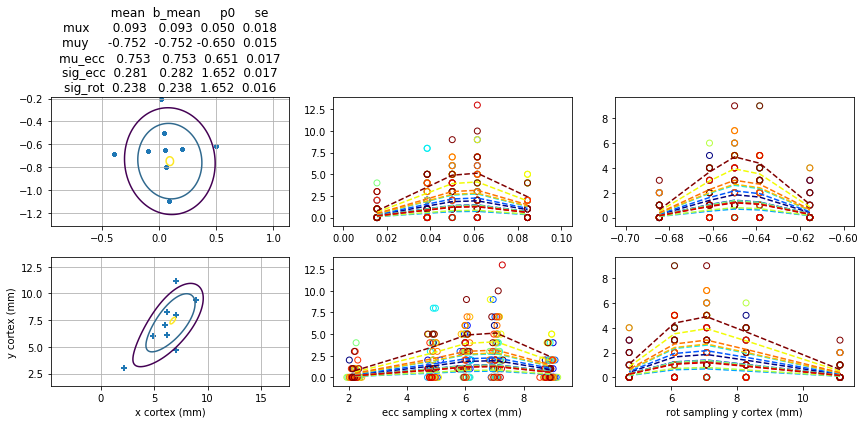

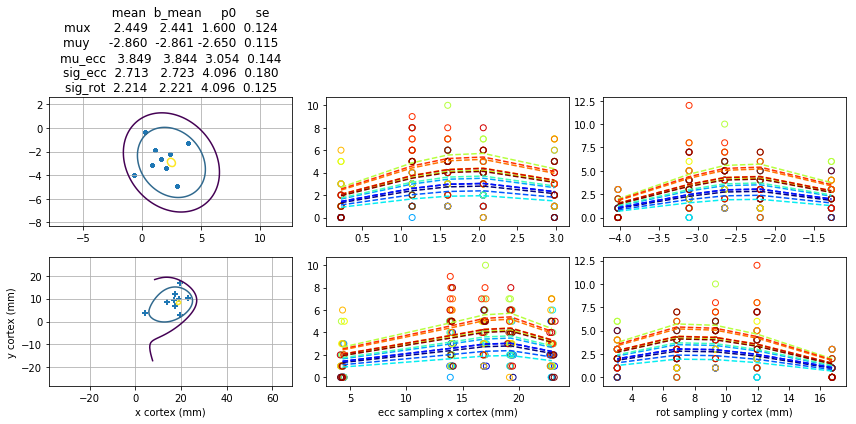

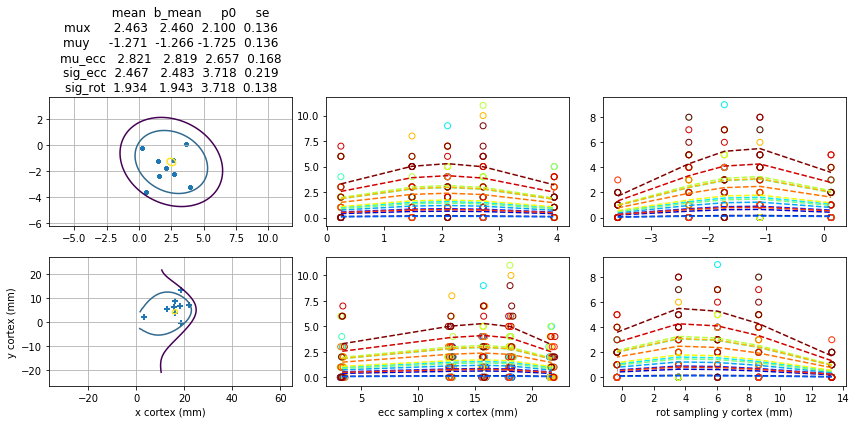

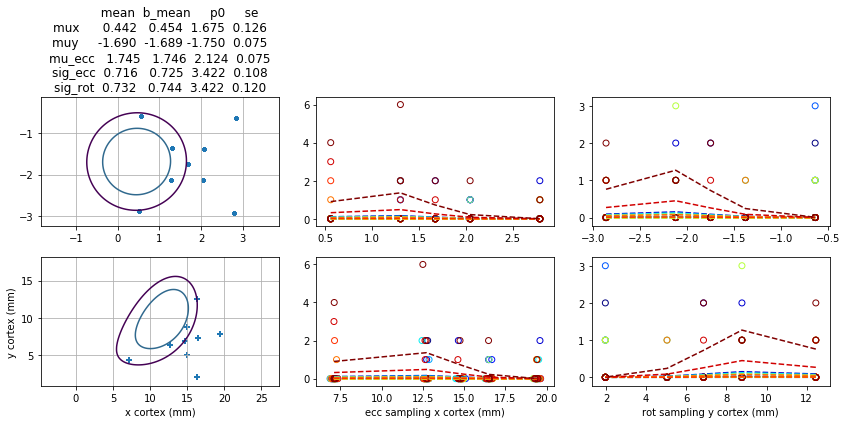

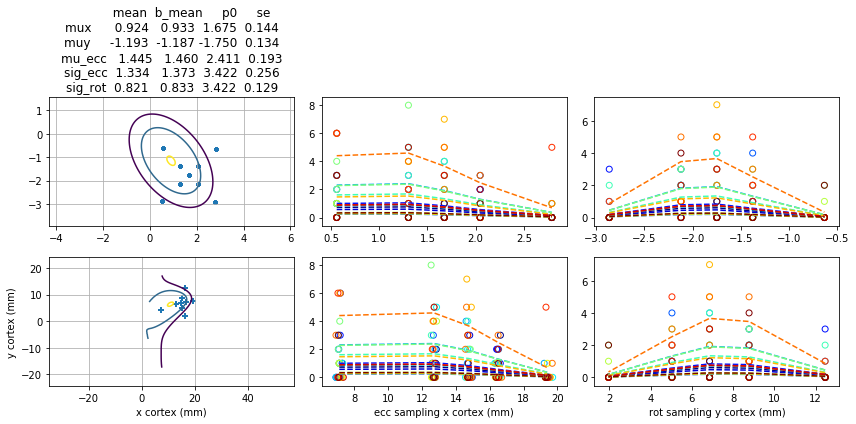

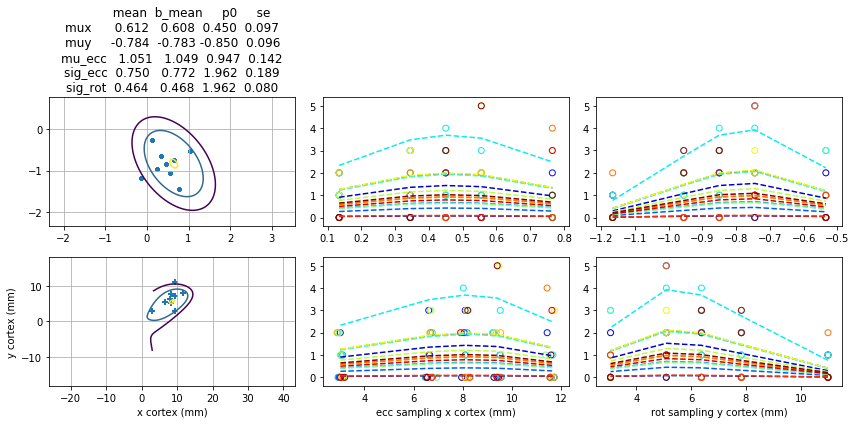

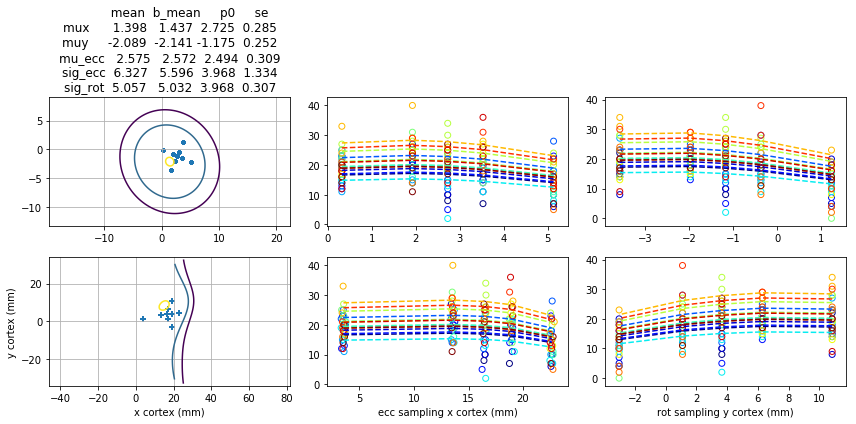

In [778]:
levels = np.array([0.25, 0.5,.99])
stims = range(15)
colors = plt.cm.jet(np.linspace(0, 1, len(stims)))
nsamp = 100

rec = 1
unit = 's'
for rec in range(len(good_units)):
    df = ds.loc[rec,unit].copy()
    fit = dfs.loc[rec,unit].copy()
    resp = df['resp']
    tc = 'c'
    tr = 'r'
    center = df[(df['ecc']==0)&(df['rot']==0)]
    mux = center['x'+tc].iloc[0]
    muy = center['y'+tc].iloc[0]

    mux, muy, mu_ecc, varx, vary = fit['b_mean'].values[:5]
    
    aval = fit['mean'].values[-1]
    print(aval)
    
    cbound = 0.1
    width = max([varx, vary])*2
    xi = np.linspace(mux-width, mux+width, nsamp)
    yi = np.linspace(muy-width, muy+width, nsamp)
    x, y = np.meshgrid(xi,yi)
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = pos.reshape((nsamp**2, 2))
    x = np.concatenate([pos, np.ones((len(pos),1))*14], 1)

    plt.figure(figsize=(12,6))
    plt.subplot(231)
    #resp_fit = gaussian2(pos, amp, mux, muy, varx, vary, r)
    #resp = plot_axis_mu_elipse(d[['xr', 'yr', 'stim_id_resp_ind']].values, )

    resp_fit = plot_axis_mu_elipse(x, *fit['b_mean'].values)

    plt.contour(x[...,0].reshape((nsamp,nsamp)), x[...,1].reshape((nsamp,nsamp)), 
                resp_fit.reshape((nsamp,nsamp)), levels=levels*(aval));
    plt.scatter(df['x'+tr], df['y'+tr], marker='.')

    #plt.scatter(xy[ecc_ind,0], xy[ecc_ind,1], color='r');plt.grid();
    #plt.scatter(xy[rot_ind,0], xy[rot_ind,1], color='b');plt.grid();
    plt.title(np.round(fit.iloc[:5][['mean', 'b_mean', 'p0', 'se']],3))
    plt.axis('equal');
    plt.grid()

    ecc = df[(df['rot']==0)][['x'+tc, 'y'+tc, 'x'+tr, 'y'+tr, 'resp', 'r_fit_ax_mu','stim_id_resp_ind']]
    ecc = ecc.set_index('stim_id_resp_ind', drop=False)
    rot = df[(df['ecc']==0)][['x'+tc, 'y'+tc, 'x'+tr, 'y'+tr,'resp', 'r_fit_ax_mu' ,'stim_id_resp_ind']]
    rot = rot.set_index('stim_id_resp_ind', drop=False)
    args = fit['mean']
    #plt.ylim(-10,10);plt.xlim(-10,10);
    
    plt.subplot(232)
    resp_fit_ecc = plot_axis_mu_elipse(rot[['x' + tr, 'y' + tr, 'stim_id_resp_ind']].values, *fit['mean'].values)
    for j , stim in enumerate(stims):
        plt.scatter(ecc['x'+tr].loc[stim], 
                 ecc['resp'].loc[stim], color=colors[j],facecolors='none')
        plt.plot(ecc['x'+tr].loc[stim], ecc['r_fit_ax_mu'].loc[stim], color=colors[j],
                 linestyle='--')

    plt.subplot(233)
    resp_fit_rot = plot_axis_mu_elipse(rot[['x' + tr, 'y' + tr, 'stim_id_resp_ind']].values, *fit['b_mean'].values)
    for j , stim in enumerate(stims):
        plt.scatter(rot['y'+tr].loc[stim], 
                 rot['resp'].loc[stim], color=colors[j], facecolors='none')
        plt.plot(rot['y'+tr].loc[stim], rot['r_fit_ax_mu'].loc[stim], color=colors[j],
                 linestyle='--')

    plt.tight_layout()

    plt.subplot(234)

    x, y = ret_to_cort(x[:,0],x[:,1])
    plt.tricontour(x, y,  resp_fit,levels=levels*(aval))
    plt.scatter(df['x'+tc], df['y'+tc], marker='+')
    plt.axis('equal');
    plt.grid()
    plt.xlabel('x cortex (mm)')
    plt.ylabel('y cortex (mm)')

    plt.subplot(235)
    resp_fit_ecc = plot_axis_mu_elipse(rot[['x'+tr, 'y' + tr, 'stim_id_resp_ind']].values, *fit['b_mean'].values)
    for j , stim in enumerate(stims):
        a_ecc = ecc['x'+tc].loc[stim].values
        jitter = np.random.randn(len(a_ecc))/10.
        plt.scatter(a_ecc + jitter, 
                 ecc['resp'].loc[stim], color=colors[j],facecolors='none')
        plt.plot(a_ecc, ecc['r_fit_ax_mu'].loc[stim], color=colors[j],
                 linestyle='--')
    plt.xlabel('ecc sampling x cortex (mm)')

    plt.subplot(236)
    resp_fit_rot = plot_axis_mu_elipse(rot[['x'+tr, 'y' + tr, 'stim_id_resp_ind']].values, *fit['b_mean'].values)
    for j , stim in enumerate(stims):
        plt.scatter(rot['y'+tc].loc[stim], 
                 rot['resp'].loc[stim], color=colors[j],facecolors='none')
        plt.plot(rot['y'+tc].loc[stim], rot['r_fit_ax_mu'].loc[stim], color=colors[j],
                 linestyle='--')
    plt.xlabel('rot sampling y cortex (mm)')
    plt.tight_layout()

## Bayesian receptive field fits

Our goal is to effectively estimate an approximation to the receptive field as a 2-d gaussian. 
Our model of the receptive field will be:

$$Y_i| \beta, \sigma^2 \sim N[\mu_i(\beta), \sigma^2]$$

with $Y_i$ 



In [767]:
fit = dfs.loc[4,'s'].copy()
aval

20.192128565063399

In [766]:
fit

,mean,b_mean,p0,p0_var,se
mux,0.923822,0.932963,1.675000,1.675000,0.143646
muy,-1.193289,-1.187477,-1.750000,-1.750000,0.134467
mu_ecc,1.439603,1.454716,2.410902,2.410902,0.195209
sig_ecc,1.338398,1.378203,3.422421,3.422421,0.258148
sig_rot,0.822343,0.834950,3.422421,3.422421,0.129129
amp_1,0.815385,0.000000,0.000000,0.000000,0.073363
amp_2,0.644184,0.646694,1.224745,1.224745,0.072930
amp_3,1.126751,1.123449,0.707107,0.707107,0.074884
amp_4,0.262034,0.000000,0.000000,0.000000,0.071382
amp_5,2.600066,2.596681,1.581139,1.581139,0.072595


In [771]:
np.ones((len(pos),1))*15

array([[ 15.],
       [ 15.],
       [ 15.],
       ..., 
       [ 15.],
       [ 15.],
       [ 15.]])